In [1]:
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Layer, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import BSpline
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np
from operator import attrgetter

from data_preprocessing import read_dataset, categorical_to_numeric

In [2]:
TEST_DATA_AMOUNT = .2

In [3]:
raw_df = read_dataset()
raw_df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [5]:
categorical_columns = ['Gender', 'Workout_Type']

for column in categorical_columns:
    print(raw_df[column].value_counts(), '\n')

Gender
Male      511
Female    462
Name: count, dtype: int64 

Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64 



### As we can see, there are two string columns (Gender and Workout_type) that happen to be categorical, so we can easily map them to numeric values. 
### Let's also define a target variable here. Let's say - Gender.

In [6]:
pd.set_option('future.no_silent_downcasting', True)
target_variable_name = 'Gender'
for column in categorical_columns:
    raw_df.loc[:, column] = categorical_to_numeric(raw_df.loc[:, column])

For column - Gender, created mapping - {'Male': 0, 'Female': 1}
For column - Workout_Type, created mapping - {'Yoga': 0, 'HIIT': 1, 'Cardio': 2, 'Strength': 3}


In [7]:
for column in categorical_columns:
    print(raw_df[column].value_counts(), '\n')

Gender
0    511
1    462
Name: count, dtype: int64 

Workout_Type
3    258
2    255
0    239
1    221
Name: count, dtype: int64 



### Data normalization

In [8]:
raw_df.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


In [9]:
features = raw_df.drop(columns=[target_variable_name])
target = raw_df[target_variable_name]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

preprocessed_df = pd.concat([scaled_df, target], axis=1)
preprocessed_df.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,0.504474,0.376581,0.445159,0.509843,0.485035,0.509293,0.504282,0.407042,0.515588,0.599071,0.512099,0.440562,0.404933,0.335611
std,0.297096,0.235901,0.255440,0.295530,0.292757,0.305294,0.228689,0.184217,0.375751,0.250377,0.272805,0.304349,0.369846,0.177529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243902,0.201335,0.240000,0.256410,0.224490,0.250000,0.360000,0.281757,0.333333,0.452000,0.318182,0.333333,0.000000,0.207623
50%,0.536585,0.333704,0.420000,0.512821,0.469388,0.500000,0.506667,0.398649,0.666667,0.648000,0.500000,0.333333,0.500000,0.315565
75%,0.756098,0.511680,0.600000,0.769231,0.734694,0.750000,0.640000,0.522297,1.000000,0.772000,0.727273,0.666667,0.500000,0.432836
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split the input dataset

In [10]:
X = preprocessed_df.drop([target_variable_name], axis=1).values  
y = preprocessed_df[target_variable_name].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_DATA_AMOUNT, random_state=1)
num_classes = len(pd.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

### Generalized model creation function

In [11]:
def create_nn_model(input_dim, layers_config, activation_functions, loss_function, metrics):
    """
    Create a flexible NN model.
    
    Args:
    - input_dim: int, number of input features.
    - layers_config: list of ints, number of neurons in each layer.
    - activation_functions: list of strings or functions, activation function for each layer.
    - loss_function: string, loss function for the model.
    - metrics: list of strings, metrics to evaluate the model on.

    Returns:
    - model: Compiled Keras model.
    """
    assert len(layers_config) == len(activation_functions), "Mismatch in layers and activations"
    
    model = Sequential()
    model.add(Input((input_dim, )))
    for i, (neurons, activation) in enumerate(zip(layers_config, activation_functions)):
        model.add(Dense(neurons))
        model.add(activation)
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss=loss_function, metrics=metrics)
    return model

### Example configuration

In [12]:
input_dim = X_train.shape[1]  # Number of input features
layers_config = [64, 32]  # Number of neurons in each layer
activation_functions = [Activation('relu'), Activation('relu')]  # Activation functions for each layer
loss_function = 'categorical_crossentropy'
metrics = ['accuracy']

In [13]:
def evaluate_model(layers_config, activation_functions, verbose = False):
    model = create_nn_model(input_dim, layers_config, activation_functions, loss_function, metrics)

    epochs = 10
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=verbose)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=verbose)
    if verbose:
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")

    return test_accuracy

In [14]:
baseline_acc = evaluate_model(layers_config, activation_functions, verbose=True)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5284 - loss: 0.7108 - val_accuracy: 0.7308 - val_loss: 0.6360
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7519 - loss: 0.6118 - val_accuracy: 0.8397 - val_loss: 0.5487
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8322 - loss: 0.5275 - val_accuracy: 0.8718 - val_loss: 0.4487
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.4395 - val_accuracy: 0.9295 - val_loss: 0.3459
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.3587 - val_accuracy: 0.9744 - val_loss: 0.2511
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9217 - loss: 0.2658 - val_accuracy: 0.9744 - val_loss: 0.1936
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9242 - loss: 0.2263 - val_accuracy: 0.9808 - val_loss: 0.1606
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9198 - loss: 0.2171 - val_accuracy: 0.9744 - val_loss

### Evolutionary algorithm

Model will be optimized from the architectural standpoint: number of layers, their size, activations over an accuracy metric. Even considering that bigger model is more powerful, smaller and better-fitting model has a chance under training time/iterations constraint.

In [15]:
# We only care about accuracy
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Individual only saves the parameters
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

MIN_LAYERS, MAX_LAYERS = 0, 5
SPLINE_SIZE = 5
BASE_HIDDEN_SIZE = 64

# Number of layers is straightforward
toolbox.register("num_layers", random.randint, 1, 5)

# As hidden size is dependent on the number of layers it would be sampled from continious function 
# Such function can be represented via spline with a set number of knots

toolbox.register("attr_float", random.random)
toolbox.register("spline_args", tools.initRepeat, list, toolbox.attr_float, n=SPLINE_SIZE)

# Same approach will be used for activation functions:
# A relu-like activation function can be formed from a spline

def build_individual(container):
    return container([toolbox.num_layers()] + toolbox.spline_args() + toolbox.spline_args())

toolbox.register("individual", build_individual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

To support spline-based activations following layers are used

In [16]:
# Based on https://www.gabormelli.com/RKB/Adaptive_Piecewise_Linear_Activation_Function

class APLActivation(Layer):
    def __init__(self, coefficients):
        super().__init__()

        self.coefficients = coefficients

    def call(self, inputs):
        activation = tf.keras.activations.relu(inputs)
        for w in self.coefficients:
            activation += tf.keras.activations.relu(w - inputs)

        return activation

# Based on https://github.com/joaquimcampos/DeepSplines/tree/main

class BSplineActivation(Layer):
    def __init__(self, coefficients):
        super().__init__()

        self.size = 5
        self.coefficients = tf.convert_to_tensor(coefficients)

        self.grid = ((float(self.size) / (int(self.size) // 2)) // 1e-6) * 1e-6
        self.grid = tf.convert_to_tensor(self.grid, dtype=tf.float32)
        self.grid = tf.keras.activations.relu(self.grid)
        
    def call(self, inputs):
        input_size = inputs.shape[1]

        activation_arange =tf.range(0, inputs.shape[1])
        knots = (activation_arange * self.size + (self.size // 2))
        knots = tf.cast(knots, tf.float32)

        inputs_clipped = tf.clip_by_value(
            inputs, 
            -(tf.get_static_value(self.grid) * (self.size // 2)), 
            (tf.get_static_value(self.grid) * (self.size // 2 - 1))
        )

        inputs_floored = tf.math.floor(inputs_clipped / self.grid)
        fractions = inputs_clipped / self.grid - inputs_floored

        indices = (tf.reshape(knots, [1, -1]) + inputs_floored)
        indices = tf.cast(indices, tf.int64)

        coefficients_expanded = tf.tile(tf.expand_dims(self.coefficients, axis=0), tf.constant([input_size, 1], tf.int32))
        coefficients_expanded = tf.reshape(coefficients_expanded, [-1, 1])

        coefficient_left = tf.gather_nd(coefficients_expanded[:,0], tf.expand_dims(indices, axis=-1))
        coefficient_right = tf.gather_nd(coefficients_expanded[:,0], tf.expand_dims(indices + 1, axis=-1))

        activation_output = coefficient_left * fractions + coefficient_right * (1 - fractions)
        return activation_output

In [17]:
def evaluate(individual, spline_activation = APLActivation):
    num_layers = min(5, max(int(individual[0]), 1))

    hidden_size_params = individual[0:5]
    
    t = np.linspace(MIN_LAYERS, MAX_LAYERS, 8)
    spl = BSpline(t, hidden_size_params, 2)
    
    xs = np.arange(num_layers)
    hidden_size = np.clip(spl(xs) * BASE_HIDDEN_SIZE, num_classes, BASE_HIDDEN_SIZE * 2).astype(int).tolist()

    activation_params = individual[5:10]
    activation = spline_activation(activation_params)
    activations = [activation] * num_layers

    return evaluate_model(hidden_size, activations),

# Individual's genes areheterogenous
# Evolution can deal with it, but it doesn't need to
# Thus, to use crossover that is more complex than splitting on point or two
# "parts" of the individuals are mated individually

def mate(ind1, ind2):
    n1, n2 = ind1[0], ind2[0]

    gamma = (1. + 2. * 0.5) * random.random() - 0.5
    n1_new = (1. - gamma) * n1 + gamma * n2
    n2_new = gamma * n1 + (1. - gamma) * n2

    ind1, ind2 = tools.cxTwoPoint(ind1[0:10], ind2[0:10])

    return creator.Individual([n1_new] + ind1), creator.Individual([n2_new] + ind2)

toolbox.register("mate", mate)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=1, low = 0, up = 5, indpb=0.1)

# Tournament does not preserve the best individuals
# But it's easy to augment it

def select(individuals, k, preserved_part, tournsize, fit_attr="fitness"):
    k_preserved = int(k * preserved_part)
    k_tournament = k - k_preserved

    preserved_best = tools.selBest(individuals, k_preserved, fit_attr=fit_attr)
    non_preserved = [ind for ind in individuals if ind not in preserved_best]

    return preserved_best + tools.selTournament(non_preserved, k_tournament, tournsize=tournsize, fit_attr=fit_attr)

toolbox.register("select", select, preserved_part=0.15, tournsize=3)
toolbox.register("evaluate", evaluate)

In [18]:
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, logbook = algorithms.eaSimple(toolbox.population(20), toolbox, cxpb=0.5, mutpb=0.15, ngen=50, stats=mstats, verbose=True)


   	      	                                fitness                                 
   	      	------------------------------------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std     
0  	20    	0.863077	0  	0.933333	0.405128	20    	0.118428
1  	8     	0.801795	1  	0.933333	0.461538	8     	0.164225
2  	11    	0.804103	2  	0.928205	0.441026	11    	0.143513
3  	15    	0.75641 	3  	0.928205	0.410256	15    	0.165041
4  	8     	0.791795	4  	0.928205	0.307692	8     	0.183747
5  	8     	0.81    	5  	0.928205	0.584615	8     	0.113731
6  	13    	0.786923	6  	0.948718	0.492308	13    	0.149278
7  	8     	0.868974	7  	0.948718	0.548718	8     	0.0831414
8  	13    	0.877949	8  	0.948718	0.579487	13    	0.0739351
9  	11    	0.883333	9  	0.948718	0.728205	11    	0.0555144
10 	13    	0.846154	10 	0.923077	0.441026	13    	0.14001  
11 	12    	0.892308	11 	0.923077	0.558974	12    	0.0770256
12 	8     	0.885128	12 	0.923077	0.441026	8     	0.102261 
13 	13    	0.

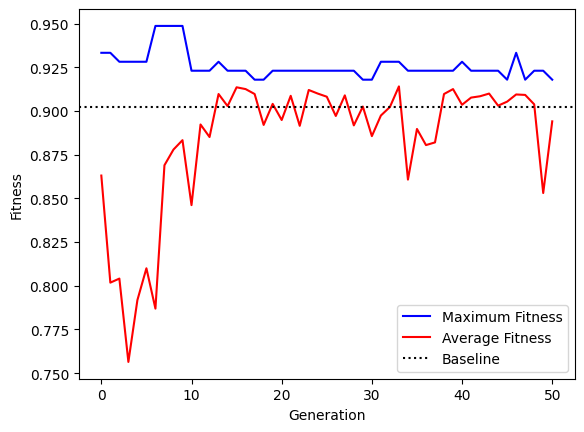

In [19]:
gen = logbook.select("gen")
fit_mins = logbook.chapters["fitness"].select("max")
fit_avg = logbook.chapters["fitness"].select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Maximum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, fit_avg, "r-", label="Average Fitness")
line3 = ax1.axhline(y = baseline_acc, color = 'black', linestyle = ':', label="Baseline")

lns = line1 + line2 + [line3]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower right")

plt.show()

Gene: [1.9446774644894864, 1.9516813562888842, 1.948421603143764, 1.9484216031437638, 1.948463948118036, 1.9485571038136973, 1.9484216031437638, 1.948463948118036, 1.9485571038136973, 1.9484229297966706, 1.9492941488689346]
Num layers: 1
Layer sizes: [122]


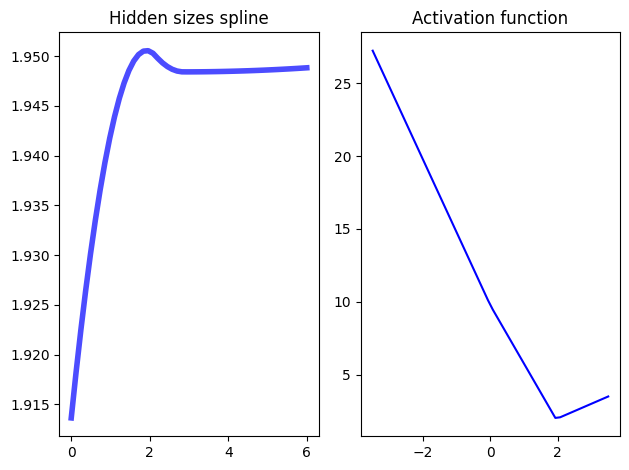

In [20]:
best_individual = sorted(pop, key=attrgetter('fitness'), reverse=True)[0]
print(f"Gene: {best_individual}")

num_layers = min(5, max(int(best_individual[0]), 1))
print(f"Num layers: {num_layers}")

hidden_size_params = best_individual[0:5]
t = np.linspace(MIN_LAYERS, MAX_LAYERS, 8)
spl = BSpline(t, hidden_size_params, 2)
xs = np.arange(num_layers)
hidden_size = np.clip(spl(xs) * BASE_HIDDEN_SIZE, num_classes, BASE_HIDDEN_SIZE * 2).astype(int).tolist()
print(f"Layer sizes: {hidden_size}")

activation_params = best_individual[5:10]

fig, ax = plt.subplots(1, 2)

# plot spline
xx = np.linspace(0, 6, 50)
ax[0].plot(xx, spl(xx), 'b-', lw=4, alpha=0.7, label='BSpline')
ax[0].set_title("Hidden sizes spline")

# plot activation
xx = np.linspace(-3.5, 3.5, 50)
relu = np.fmax(0, xx)
activation = relu
for w in activation_params:
   activation += np.fmax(0, w - xx)

ax[1].plot(xx, activation, 'b-', label='Activation')
ax[1].set_title("Activation function")

fig.tight_layout()
plt.show()